In [ ]:
#!pip install torch==1.9.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install torch==1.9.1+cpu torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install torchaudio

In [31]:
#!pip install audtorch
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import torch
import os
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import clear_output
import tqdm.notebook as tqdm
#import audtorch
%matplotlib inline

In [33]:
from utils.dataloader import make_sorted_dataloader
from utils.chunk_dataset import ChunkDataSet
from utils.zip_dataset import ZippedDataSet

In [34]:
# from google.colab import drive
# drive.mount('/content/drive')

In [35]:
# !ls /content/drive/MyDrive/учебка/магистратура/ULM/Data/

In [36]:
#[w for w in os.listdir('/content/drive/MyDrive/учебка/магистратура/ULM/Data/030_2016-04-06_Nottingham')]

In [37]:
# ! ls /content/drive/MyDrive/учебка/магистратура/ULM/Data/031_2016-04-06_Nottingham/

In [38]:
# ! head /content/drive/MyDrive/учебка/магистратура/ULM/Data/031_2016-04-06_Nottingham/VAD_expert.annotation~

In [39]:
ds = ChunkDataSet('./data/Data/')

15414 chunks


In [40]:
for k in range(10):
    print([i.shape for k, i in ds[k].items() if not isinstance(i, int)])

[torch.Size([80, 50]), torch.Size([50]), torch.Size([50])]
[torch.Size([80, 50]), torch.Size([50]), torch.Size([50])]
[torch.Size([80, 50]), torch.Size([50]), torch.Size([50])]
[torch.Size([80, 50]), torch.Size([50]), torch.Size([50])]
[torch.Size([80, 50]), torch.Size([50]), torch.Size([50])]
[torch.Size([80, 50]), torch.Size([50]), torch.Size([50])]
[torch.Size([80, 50]), torch.Size([50]), torch.Size([50])]
[torch.Size([80, 50]), torch.Size([50]), torch.Size([50])]
[torch.Size([80, 50]), torch.Size([50]), torch.Size([50])]
[torch.Size([80, 50]), torch.Size([50]), torch.Size([50])]


In [41]:

zip_ds = ZippedDataSet('data/ds_chunk2s.zip', None, rewrite=False)


zip_fname='data/ds_chunk2s.zip' exists! Using that archive


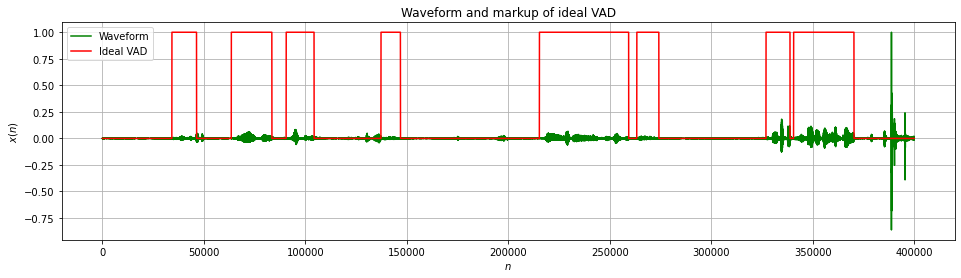

In [42]:
train_ds, val_ds = zip_ds.train_test_split()    

In [43]:
class MsePadLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = torch.nn.MSELoss(reduction='none')

    def forward(self, y1, y2, pad=None):
        btz = y1.shape[0]
        if pad is None:
            pad = torch.ones_like(y1)
        loss = (self.loss(y1.view(btz, -1), y2.view(btz, -1))*pad).sum(dim=1) / pad.sum()
        return loss.mean()

    

In [44]:
class PearsonLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

    def forward(self, y1, y2, pad=None):
        if pad is None:
            pad = torch.ones_like(y1)
        vec1 = (y1 - y1.sum(dim=1, keepdim=True) /pad.sum(dim=1, keepdim=True))*pad
        vec2 = (y2 - y2.sum(dim=1, keepdim=True) /pad.sum(dim=1, keepdim=True))*pad
        pearson = self.cos(vec1, vec2)
        return 1 - pearson.mean()

def test_pearson():
    rng = np.random.default_rng(seed=42)
    xarr = rng.random((5, 100))
    R1 = np.corrcoef(xarr)
    print(f'{R1=}')
    c = PearsonLoss()
    xarr = torch.from_numpy(xarr)
    for i, row in enumerate(R1):
        for j, corr in enumerate(row):
            p = c(xarr[i:i+1], xarr[j:j+1]).numpy()
            assert np.allclose(1 - corr.mean(), p), f'{corr=} {p=}'
            
    print(f'Test passed')
test_pearson()

R1=array([[ 1.        , -0.13671059, -0.04628066,  0.1328244 ,  0.00430322],
       [-0.13671059,  1.        ,  0.01779632, -0.00960732,  0.05874123],
       [-0.04628066,  0.01779632,  1.        , -0.13468386,  0.01125721],
       [ 0.1328244 , -0.00960732, -0.13468386,  1.        ,  0.08674649],
       [ 0.00430322,  0.05874123,  0.01125721,  0.08674649,  1.        ]])
Test passed


In [45]:
class CNN_blstm(torch.nn.Module):
  def __init__(self, feats_in=80):
    super().__init__()
    # self.cnn = torch.nn.Sequential(*(
    # torch.nn.Conv2d(1, 32, 5, padding=(0, 2)),
    # # torch.nn.BatchNorm2d(32),
    # # #torch.nn.MaxPool2d((2, 1)), # //2 (7)
    # # torch.nn.ReLU(),
    # # torch.nn.Conv2d(32, 16, 3, padding=(0, 1)),
    # # torch.nn.BatchNorm2d(16),
    # # #torch.nn.MaxPool2d((2, 1)), # //4 (btz X 8 X 2 X sl)
    # # #torch.nn.ReLU(),
    # # # torch.nn.Conv2d(8, 16, 5, padding=(0, 2)),
    # # # torch.nn.BatchNorm2d(16),
    # # # torch.nn.MaxPool2d((2, 1)), # //8 (10)
    # # # torch.nn.ReLU(),
    # # # torch.nn.Conv2d(16, 16, 5, padding=(0, 2)),
    # # # torch.nn.BatchNorm2d(16),
    # # # torch.nn.MaxPool2d((2, 1)), # //16 (btz X 16 X 1 X sl)
    # torch.nn.ReLU())) # 
    self.blstm = torch.nn.LSTM(feats_in, 512, batch_first=True, dropout=0.3, bidirectional=True, num_layers=3)
    
    # self.head_cnn = torch.nn.Sequential(torch.nn.Conv1d(1024, 512, kernel_size=5, padding=2), 
    #                                 torch.nn.ReLU(),
    #                                 torch.nn.Conv1d(512, 256, kernel_size=3, padding=1),)
    self.head = torch.nn.Linear(512*2, 1)
    self.sig = torch.nn.Sigmoid() # torch.nn.Tanh() 

  def forward(self, feats):
    btz, num_feats, seq_len = feats.shape
    #feats = feats.unsqueeze(dim=1)
    #cnn_out = self.cnn(feats)
    #btz, channels, num_feats, seq_len = cnn_out.shape
    #print(cnn_out.shape)
    blstm_in = feats.transpose(1,2) #cnn_out.view((cnn_out.shape[0], channels *num_feats, seq_len)).transpose(1, 2)
    blstm_out, _ = self.blstm(blstm_in)
    #hcnn = self.head_cnn(blstm_out.transpose(1,2))
    logits = self.head(blstm_out.mean(dim=1)) #hcnn.transpose(1,2))
    return self.sig(logits.view(btz, 1))

  

In [46]:
from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import Conv2dStaticSamePadding
from torch import nn
import torch.nn.functional as F

class EfficientNetASR(nn.Module):                                                                                                                                                                 
    def __init__(self, efficient_net_version='b0'):                                                                                                                                         
        super().__init__()
        assert efficient_net_version is not None
        self.efficientnet_model = EfficientNet.from_pretrained('efficientnet-%s' % efficient_net_version)                                                                                                                                                             
        self.efficientnet_model._conv_stem = Conv2dStaticSamePadding(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False, image_size=(128, 188))   
        self.fc = nn.Linear(1000, 256, bias=True)                                                                                                                                  
        self.dropout = nn.Dropout(0.3)
        self.head = nn.Linear(256, 1)
        self.sig = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = x.unsqueeze(dim=1)
        x = F.relu(self.efficientnet_model(x))
        x = self.dropout(x)
        x = F.relu(self.fc(x))
        x = self.head(x)
        #print(x.shape)
        return self.sig(x)


In [47]:
device='cuda'

In [58]:
def eval(model, dataloader, device='cpu'):
    losses = []
    with torch.no_grad():
        for batch in dataloader:
            x_batch = batch['feats'].to(device) #btz X feat_dim X seq_len
            y_batch = batch['labels'].to(device)
            pad_batch = batch['padding'].to(device)
            #print(x_batch.shape, y_batch.shape)

            logits = model(x_batch) #* pad_batch

            logits_mean = logits.mean(dim=1)#/pad_batch.sum(dim=1)
            y_mean = y_batch.sum(dim=1)/pad_batch.sum(dim=1)
            loss = ((y_mean - logits_mean)**2).mean().cpu().item()
            losses.append(loss)
    return np.mean(losses)

def train_per_chunk(model, train_dl, val_dl, epochs=10, device='cpu', lr=1e-3, p_m=[0.5, 0.5]):
    optimizer=torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)
    #optimizer=torch.optim.SGD(model.parameters(), lr=0.000001, momentum=0.9)
    #criterion = lambda x, y: -torch.exp(audtorch.metrics.functional.pearsonr(x, y, batch_first=True)) # 1e-13 #TODO scipy check
    
    # criterion_mse = MsePadLoss()
    # critreion_pea = PearsonLoss()
    
    train_losses = []
    val_losses = []
    last_val = float('inf')
    t1 = tqdm.tqdm(range(1, epochs+1))
    for e in t1:
        #print(f'Epoch {e}/{epochs}')
        #tqdm.tqdm
        losses = []
        t2 = (train_dl)
        for batch in t2:
            x_batch = batch['feats'].to(device) #btz X feat_dim X seq_len
            y_batch = batch['labels'].to(device)
            pad_batch = batch['padding'].to(device)
            #print(x_batch.shape, y_batch.shape)

            logits = model(x_batch) #* pad_batch
            
            logits_mean = logits.mean(dim=1)#/pad_batch.sum(dim=1)
            y_mean = y_batch.sum(dim=1)/pad_batch.sum(dim=1)
            y_var = 1 #(0.66 - y_mean)**2
            loss = ((y_mean - logits_mean)**2 * y_var).mean()
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().item())

            t1.set_description(desc=f"Ep {e}, loss={losses[-1]:.5f}, val={last_val:.5f}")
            #break
        optimizer.param_groups[0]['lr'] *=0.95
        train_losses.append(np.mean(losses))
        last_val = eval(model, val_dl, device=device)
        val_losses.append(last_val)
        
    plt.figure(figsize=(8, 8)); plt.title('Train losses')
    plt.xlabel('iter') ; plt.ylabel('mse'); plt.grid()
    plt.plot(train_losses, label='train loss')
    plt.plot(val_losses, label='val loss')
    plt.legend()
    plt.show()
    return model 

In [59]:
btz=128
train_dl = make_sorted_dataloader(train_ds, batch_size=btz)
val_dl = make_sorted_dataloader(val_ds, batch_size=btz)

Loaded pretrained weights for efficientnet-b1


  0%|          | 0/20 [00:00<?, ?it/s]

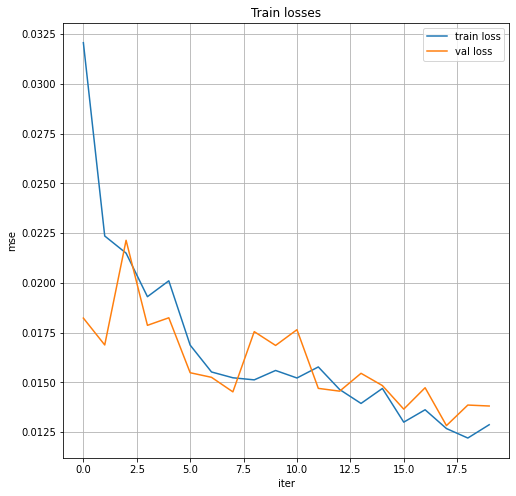

In [62]:
model = EfficientNetASR('b1').to(device)
#model = CNN_blstm().to(device)
model = train_per_chunk(model, 
                        train_dl, val_dl, lr=2e-4, # egs_list=['028_2016-04-06_Nottingham']
                        epochs=20, device=device)
torch.save(model, 'models/effnet.chunk.2.pt')
# train= val=0.01172. btz=40, epochs=60, lr=1e-4
# train= val=0.01155. btz=128, epochs=60, lr=1e-4
# train= val=. btz=128, epochs=60, lr=1e-3
# train= val=. btz=128, epochs=60, lr=1e-5
# mse^2 train= val=0.01417. btz=128, epochs=60, lr=1e-3


In [63]:
model = torch.load('models/effnet.chunk.2.pt')

In [64]:
eval(model, val_dl, device=device)

0.013951944429427385

In [65]:
from sklearn.metrics import classification_report
def brackets_acccuracy(model, dl, device='cpu', n=4):
    brackets_l = np.linspace(0, 1.01, n+1)[:-1]
    brackets_r = np.linspace(0, 1.01, n+1)[1:]
    predicted=[]
    truth=[]
    with torch.no_grad():
        for batch in dl:
            x = batch['feats'].to(device) 
            p = batch['padding']
            labels = batch['labels'].sum(dim=1)/p.sum(dim=1)
            labels = labels.view(-1).numpy() 
            
            logits = model(x).cpu().view(-1).numpy()
            assert labels.shape == logits.shape, f' {labels.shape=} {logits.shape=}'
            for l, y in zip(logits, labels):
                pos_l = np.where((brackets_l <= l) * (brackets_r > l))[0]
                pos_y = np.where((brackets_l <= y) * (brackets_r > y))[0]
                assert pos_l.shape == pos_y.shape == (1,), f'{pos_l=} {pos_y=}'
                predicted.append(pos_l[0])
                truth.append(pos_y[0])
    #print([(y,p) for y,p in zip(truth, predicted)])
    print(classification_report(truth, predicted, target_names=[f'[{l:.2f},{r:.2f})' for l,r in zip(brackets_l, brackets_r)]))
    
brackets_acccuracy(model, val_dl, device=device)

              precision    recall  f1-score   support

 [0.00,0.25)       0.00      0.00      0.00        50
 [0.25,0.51)       0.31      0.42      0.35       298
 [0.51,0.76)       0.79      0.89      0.84      2369
 [0.76,1.01)       0.67      0.02      0.04       361

    accuracy                           0.73      3078
   macro avg       0.44      0.33      0.31      3078
weighted avg       0.72      0.73      0.68      3078



/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [152]:
n=10
brackets_l = np.linspace(0, 1.01, n+1)[:-1]
brackets_r = np.linspace(0, 1.01, n+1)[1:]
bins = np.zeros(n)
logits = np.array([0.01, 0.002, 0, 0.11, 0.99, 0.55, 1.])
for l in logits:
    pos = (brackets_l <= l) * (brackets_r > l)
    print(l, pos)
    print(np.where(pos)[0])
    #bins[pos]+=1
#print(bins)

0.01 [ True False False False False False False False False False]
[0]
0.002 [ True False False False False False False False False False]
[0]
0.0 [ True False False False False False False False False False]
[0]
0.11 [False  True False False False False False False False False]
[1]
0.99 [False False False False False False False False False  True]
[9]
0.55 [False False False False False  True False False False False]
[5]
1.0 [False False False False False False False False False  True]
[9]


In [54]:
def predict(self, dl, device='cpu'):
    #feats - feats_dim X seq_len
    predicts = []
    labels = []
    padds = []
    # #torch.utils.data.DataLoader(ds, 
    #                                            collate_fn=collate,
    #                                            sampler=SortedSampler(ds), 
    #                                            shuffle=False, 
    #                                            batch_size=64):
    with torch.no_grad():
        for batch in dl: 
            x = batch['feats'].to(device) 
            y = batch['labels'] 
            p = batch['padding']
            logits = model(x).cpu()
            predicts.append(logits.cpu())
            labels.append(y.cpu())
            padds.append(p.cpu())
    return predicts, labels, padds

#ds = FolderDataSet('/content/drive/MyDrive/учебка/магистратура/ULM/Data/',  novices=False) # egs_list=['030_2016-04-06_Nottingham'],

plp = predict(model, val_dl, device=device)      

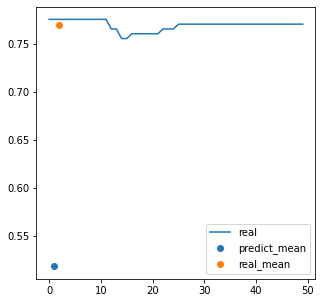

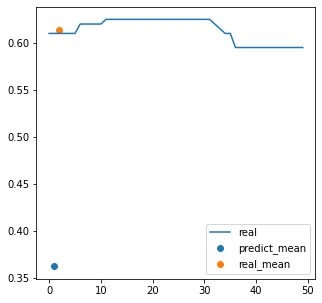

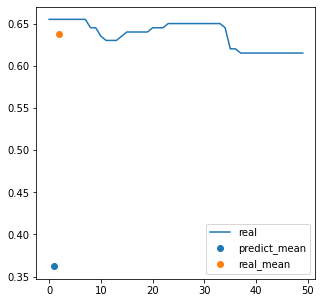

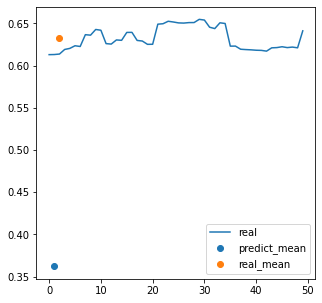

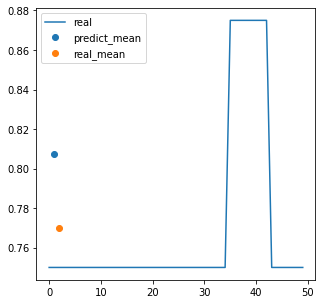

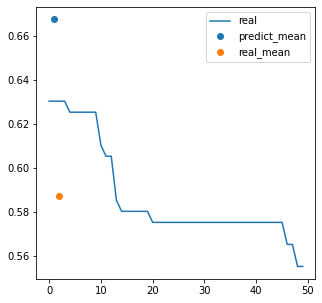

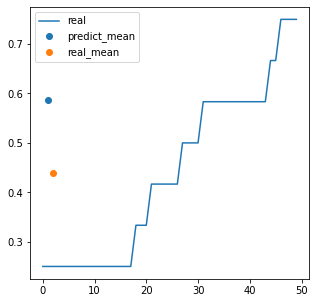

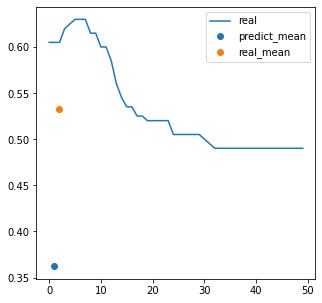

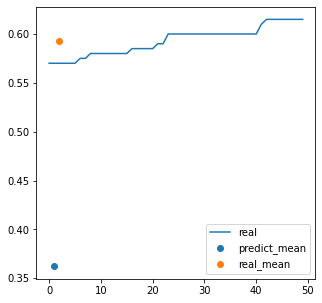

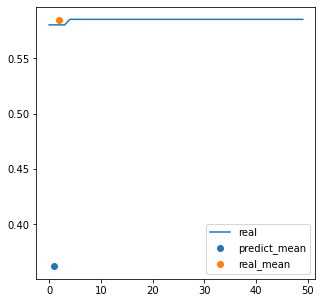

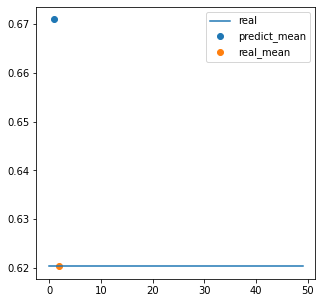

In [55]:
for p_batch, l_batch, pad_batch in zip(*plp):
    for i in range(p_batch.shape[0]):
        one_pads = pad_batch[i, :]
        one_predict = p_batch[i, :].mean() #[one_pads==1].mean()
        one_label = l_batch[i, :][one_pads==1]
        l_mean = one_label.mean()
        #deltas
        # one_predict = one_predict[:-1]
        # one_label = one_label[1:] - one_label[:-1]
        #
        x = np.arange(len(one_label))
        plt.figure(figsize=(5,5))
        #plt.plot(x, one_predict)
        plt.plot(x, one_label)
        plt.scatter(1, one_predict)
        plt.scatter(2, l_mean)
        plt.legend(['real', 'predict_mean', 'real_mean'])
        plt.show()
        if i >=10:
            break
    break

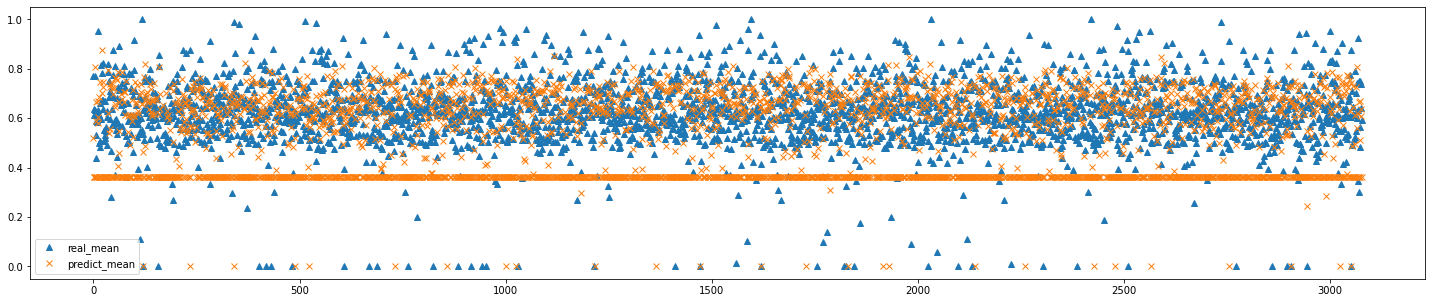

In [56]:
l_mean=[]
predicted_mean=[]
for p_batch, l_batch, pad_batch in zip(*plp):
    predicted_mean.append(p_batch.view(-1)) #.sum(dim=1)/pad_batch.sum(dim=1)
    #one_label = l_batch[i, :][one_pads==1]
    l_mean.append(l_batch.sum(dim=1)/pad_batch.sum(dim=1))
    #deltas
    # one_predict = one_predict[:-1]
    # one_label = one_label[1:] - one_label[:-1]
    #
predicted_mean = torch.cat(predicted_mean)
l_mean = torch.cat(l_mean)
x = np.arange(len(l_mean))
plt.figure(figsize=(25,5))
#plt.plot(x, one_predict)
#plt.plot(x, one_label)
plt.plot(x,  l_mean, '^')
plt.plot(x, predicted_mean, 'x')
#plt.scatter(1, one_predict)
#plt.scatter(2, l_mean)
plt.legend(['real_mean', 'predict_mean'])
plt.show()


In [57]:
for p_batch, l_batch, pad_batch in zip(*plp):
    for i in range(p_batch.shape[0]):
        one_pads = pad_batch[i, :]
        one_predict = p_batch[i, :][one_pads==1]
        one_label = l_batch[i, :][one_pads==1]
        #deltas
        # one_predict = one_predict[:-1]
        # one_label = one_label[1:] - one_label[:-1]
        #
        x = np.arange(len(one_predict))
        plt.figure(figsize=(5,5))
        plt.plot(x, one_predict)
        plt.plot(x, one_label)
        plt.legend(['predicted', 'real'])
        plt.show()
        if i >=3:
            break

IndexError: The shape of the mask [51] at index 0 does not match the shape of the indexed tensor [1] at index 0

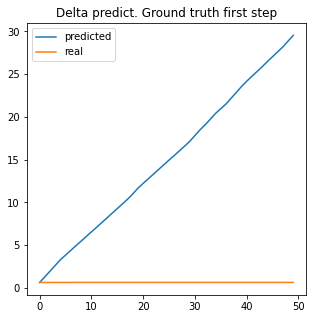

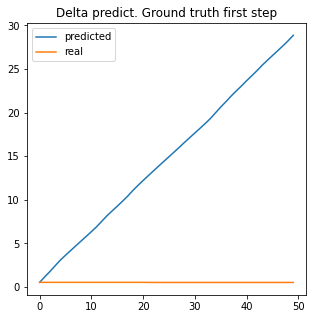

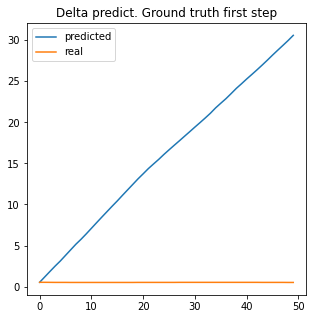

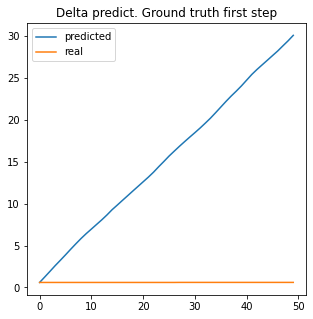

In [239]:
for p_batch, l_batch, pad_batch in zip(*plp):
    for i in range(p_batch.shape[0]):
        one_pads = pad_batch[i, :]
        one_predict = p_batch[i, :][one_pads==1]
        one_label = l_batch[i, :][one_pads==1]
        #deltas
        one_predict[0] = one_label[0]
        for j in range(1, len(one_predict)):
            one_predict[j] += one_predict[j-1]
        #one_label = one_label[1:] - one_label[:-1]
        #
        x = np.arange(len(one_predict))
        plt.figure(figsize=(5,5))
        plt.title("Delta predict. Ground truth first step")
        plt.plot(x, one_predict)
        plt.plot(x, one_label)
        plt.legend(['predicted', 'real'])
        plt.show()
        if i >=10:
            break

In [208]:
p_batch.shape

torch.Size([4, 50])

In [ ]:
l_batch.shape

In [ ]:
#for idx in random_idxes:
ipd.display(ipd.Audio(item['expert_wav'][0, :25*chk_len*16], rate=16000))

Норм лоссы: 
1. корреляция пирсона
2. concoded correlation coefficient (CCC) 

In [ ]:
def scan_rootdir(rootdir: str, channels=CHANNELS) -> List[DataFolderMetaInfo]:
    """Return List of DataFolderMetaInfo"""
    return [DataFolderMetaInfo.build_from_dir(d, c) for d in glob(f'{rootdir}/*') 
                                                     for c in channels]
# def load_vad(fname, orig_wav, sr):
#   df = pd.read_csv(fname, names=['start', 'end', 'zero', 'label'], sep=';')
#   vad = torch.zeros_like(orig_wav)
#   for i, row in  df.iterrows():
#     start = round(row['start']*sr)
#     end = round(row['end']*sr)
#     vad[start:end] = row['label']
#   return vad

# def load_data_from_dir(dir, load_expert=True, load_novice=True, clean_wavs=False, load_labels=True, sr=16000):
#   return_dict={'sr': sr}
#   if load_expert:
#     if clean_wavs:
#       expert_fname = os.path.join(dir, 'expert.audio[48000]_clean.wav')
#     else:
#       expert_fname = os.path.join(dir, 'expert.audio[48000].wav')
#     expert_wav, orig_freq = torchaudio.load(expert_fname)
#     return_dict['expert_wav'] = torchaudio.functional.resample(expert_wav, orig_freq=orig_freq, new_freq=sr)

#     if load_labels:
#       expert_labels_ds = pd.read_csv(os.path.join(dir, 'engagement_expert.annotation~'), 
#                                      names=['expert_1', 'expert_2'], sep=';').fillna(0)
#       return_dict['expert_labels'] = torch.from_numpy(expert_labels_ds['expert_1'].values).float()

#     vad_fname=os.path.join(dir, 'VAD_expert.annotation~')
#     if os.path.exists(vad_fname):
#       return_dict['expert_vad'] = load_vad(vad_fname, return_dict['expert_wav'][0], sr)

#   if load_novice:
#     if clean_wavs:
#       novice_fname = os.path.join(dir, 'novice.audio[48000]_clean.wav')
#     else:
#       novice_fname = os.path.join(dir, 'novice.audio[48000].wav')
#     novice_wav, orig_freq = torchaudio.load(novice_fname)
#     return_dict['novice_wav'] = torchaudio.functional.resample(novice_wav, orig_freq=orig_freq, new_freq=sr)


#     if load_labels:
#       novice_labels_ds = pd.read_csv(os.path.join(dir, 'engagement_novice.annotation~'), 
#                                      names=['novice_1', 'novice_2'], sep=';').fillna(0)
#       return_dict['novice_labels'] = torch.from_numpy(novice_labels_ds['novice_1'].values).float()
#     vad_fname=os.path.join(dir, 'VAD_novice.annotation~')
#     if os.path.exists(vad_fname):
#       return_dict['novice_vad'] = load_vad(vad_fname, return_dict['novice_wav'][0], sr)
#   return return_dict

  
# # feature_extractor=torch.nn.Sequential(torchaudio.transforms.MelSpectrogram(sample_rate=16000, 
# #                                                                                     n_fft=800, 
# #                                                                                     win_length=800,
# #                                                                                     hop_length=400, # Must eq == 25mc
# #                                                                                     n_mels=80, normalized=True),
# #                                                                    torchaudio.transforms.AmplitudeToDB())
# class FolderDataSet:
#   def __init__(self, folder, feature_extractor=torchaudio.transforms.MFCC(n_mfcc=13),
#                experts=True, novices=True, egs_list=None
#                ):
#     self.folder = folder
#     if not egs_list:
#       self.egs_list = os.listdir(folder)
#     else:
#       self.egs_list = egs_list
#     self.experts=experts
#     self.novices=novices
#     self.feature_extractor = feature_extractor

#   def __len__(self):
#     return len(self.egs_list)

#   # def pad_labels(self, labels, feats):
#   #   if feats.shape[-1] == labels.shape[-1]:
#   #     return labels
#   #   if feats.shape[-1] < labels.shape[-1]:
#   #     assert len(labels.shape)==2
#   #     return labels[:, :feats.shape[-1]]
#   #   pad_shape = (0, feats.shape[-1] - labels.shape[-1])
#   #   return torch.nn.functional.pad(labels, pad_shape)

#   def __getitem__(self, index):
#     dirname = self.egs_list[index]
#     return_dict = load_data_from_dir(os.path.join(self.folder, dirname), 
#                                      load_expert=self.experts, 
#                                      load_novice=self.novices)
#     if self.experts:
#       feats =  self.feature_extractor(return_dict['expert_wav']).squeeze()
#       return_dict['expert_feats'] = feats[:, :return_dict['expert_labels'].shape[-1]]
      
#       #return_dict['expert_labels'] = self.pad_labels(return_dict['expert_labels'], return_dict['expert_feats'])
#     if self.novices:
#       feats =  self.feature_extractor(return_dict['novice_wav']).squeeze()
#       return_dict['novice_feats'] = feats[:, :return_dict['novice_labels'].shape[-1]]
#       #return_dict['novice_labels'] = self.pad_labels(return_dict['novice_labels'], return_dict['novice_feats'])
#     return return_dict
  
#   def collate(self, samples):
#     x_keys=[]
#     y_keys=[]
#     if self.experts:
#       x_keys.append('expert_feats')
#       y_keys.append('expert_labels')
#     if self.novices:
#       x_keys.append('novice_feats')
#       y_keys.append('novice_labels')
#     f_dim = samples[0][x_keys[0]].shape[0] 
#     #self.feature_extractor.n_mels
#     x = [d[k].reshape(-1) for d in samples for k in x_keys]
#     btz= len(x)
#     x_batch = torch.nn.utils.rnn.pad_sequence(x, batch_first=True, padding_value=0.0).view((btz, f_dim, -1)) #btz X feat_dim X seq_len
#     if y_keys:
#       y = [d[k] for d in samples for k in y_keys]
#       y_batch = torch.nn.utils.rnn.pad_sequence(y, batch_first=True, padding_value=0.0)
#     else:
#       y_batch=None
#     return x_batch, y_batch


